# Prototyping 1D EFGP 

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

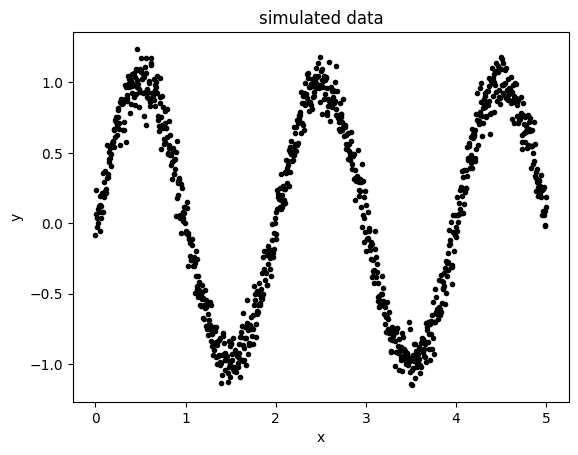

In [2]:
# generate data 
N = 1000
freq = 0.5    
x = torch.linspace(0, 5 ,N)
y = torch.sin(2 * torch.pi * freq * x) + torch.randn(N) * 0.1

# plot data
plt.plot(x, y, 'k.')
plt.xlabel('x')
plt.ylabel('y')
plt.title('simulated data')
plt.show()


In [3]:
from utils.kernels import get_xis
from kernels.squared_exponential import SquaredExponential

kernel = SquaredExponential(dimension=1, lengthscale=0.1, variance=1.0)

In [4]:
# Determine problem geometry
L = x[-1] - x[0]
N = x.shape[0]
EPSILON = 1e-5
xis, h, mtot = get_xis(kernel_obj=kernel, eps=EPSILON, L=L, use_integral=False, l2scaled=False)


In [5]:
print("Mtot: ", mtot)
print("h: ", h)
print("xis: ", xis)

Mtot:  97
h:  tensor(0.1809)
xis:  tensor([-8.6813, -8.5005, -8.3196, -8.1387, -7.9579, -7.7770, -7.5962, -7.4153,
        -7.2344, -7.0536, -6.8727, -6.6919, -6.5110, -6.3301, -6.1493, -5.9684,
        -5.7876, -5.6067, -5.4258, -5.2450, -5.0641, -4.8832, -4.7024, -4.5215,
        -4.3407, -4.1598, -3.9789, -3.7981, -3.6172, -3.4364, -3.2555, -3.0746,
        -2.8938, -2.7129, -2.5321, -2.3512, -2.1703, -1.9895, -1.8086, -1.6277,
        -1.4469, -1.2660, -1.0852, -0.9043, -0.7234, -0.5426, -0.3617, -0.1809,
         0.0000,  0.1809,  0.3617,  0.5426,  0.7234,  0.9043,  1.0852,  1.2660,
         1.4469,  1.6277,  1.8086,  1.9895,  2.1703,  2.3512,  2.5321,  2.7129,
         2.8938,  3.0746,  3.2555,  3.4364,  3.6172,  3.7981,  3.9789,  4.1598,
         4.3407,  4.5215,  4.7024,  4.8832,  5.0641,  5.2450,  5.4258,  5.6067,
         5.7876,  5.9684,  6.1493,  6.3301,  6.5110,  6.6919,  6.8727,  7.0536,
         7.2344,  7.4153,  7.5962,  7.7770,  7.9579,  8.1387,  8.3196,  8.5005,
     

In [6]:
minus_mh_to_mh = torch.arange(-((mtot-1)/2)*h, ((mtot-1)/2)*h + h)
print("minus_mh_to_mh: ", minus_mh_to_mh)
# assert torch.allclose(minus_mh_to_mh, xis), "minus_mh_to_mh and xis are not the same"


minus_mh_to_mh:  tensor([-8.6813, -7.6813, -6.6813, -5.6813, -4.6813, -3.6813, -2.6813, -1.6813,
        -0.6813,  0.3187,  1.3187,  2.3187,  3.3187,  4.3187,  5.3187,  6.3187,
         7.3187,  8.3187])


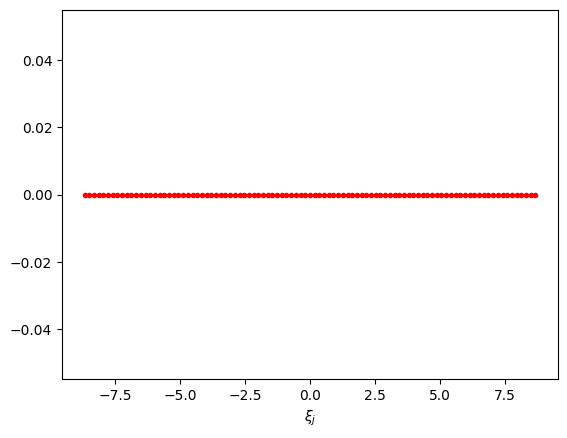

In [7]:
# plot a line with tics on the xis
plt.plot(xis, torch.zeros(mtot), 'r.')
plt.xlabel(r'$\xi_j$')
plt.show()

In [8]:
ws = torch.sqrt(kernel.spectral_density(xis).to(dtype=torch.complex128) * h)
D = torch.diag(ws).to(dtype=torch.complex128)

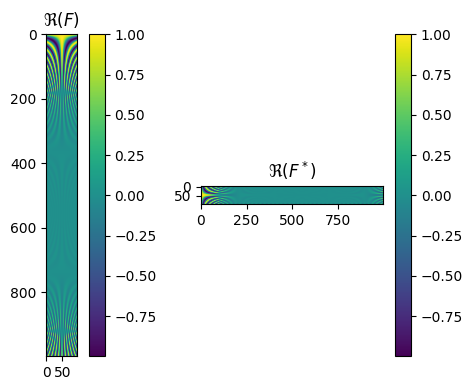

In [9]:
# Form design matrix F
# We do so manually here for clarity (no FFT / NUFFT)
F = torch.exp(1j * 2 * torch.pi * torch.outer(x, xis))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 4))

im1 = ax1.imshow(F.real)
plt.colorbar(im1, ax=ax1)
ax1.set_title(r'$\Re(F)$')

im2 = ax2.imshow(F.conj().T.real)
plt.colorbar(im2, ax=ax2)
ax2.set_title(r'$\Re(F^*)$')

plt.tight_layout()
plt.show()

# ws_diag = torch.diag(ws).to(dtype=Phi.dtype) # complex dtype
# A = ws_diag @ (Phi.T @ Phi) @ ws_diag


In [10]:
# create a matrix of distances between x's
dist_matrix = torch.cdist(x.unsqueeze(-1), x.unsqueeze(-1))
kernel_matrix = kernel.kernel(dist_matrix)

In [11]:
ws = ws.to(dtype=torch.complex128)
F = F.to(dtype=torch.complex128)
A = D @ (torch.conj(F).T @ F) @ D
kernel_approx =  ((F @ torch.diag(ws)) @ (torch.diag(ws) @ torch.conj(F).T))
# right_hand_side = torch.diag(ws) @ (F.adjoint() @ y.to(dtype=torch.complex128))
# beta_test = torch.randn_like(right_hand_side)
# sigmasq = torch.tensor(0.1)
# dense_result = (A + sigmasq * torch.eye(mtot, dtype=A.dtype)) @ beta_test
# from efgp1d import FFTConv1d, compute_convolution_vector_vectorized
# v, j_indices = compute_convolution_vector_vectorized(m=int((mtot - 1) / 2), x=x, h=h)
# Afun = lambda beta: D @ FFTConv1d(v, D @ beta)() + sigmasq * beta
# fft_result = Afun(beta_test)


In [12]:
# print("Dense magnitude:", torch.norm(dense_result))
# print("FFT magnitude:", torch.norm(fft_result))
# print("Dense type:", dense_result.dtype)
# print("FFT type:", fft_result.dtype)

Text(0.5, 0.98, 'Approximating kernel matrix with equispaced features, N = 1000, M = 97')

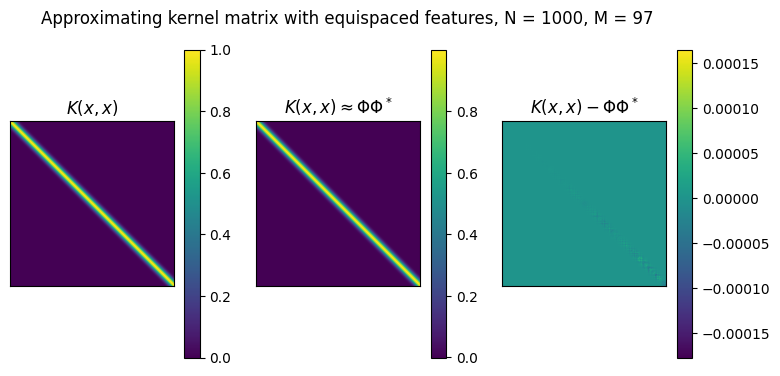

In [13]:
# subplot kernel matrix, kernel approx, and difference side by side
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9, 4))

im1 = ax1.imshow(kernel_matrix)
plt.colorbar(im1, ax=ax1)
ax1.set_title(r'$K(x, x)$')
# no axis labels
ax1.set_xticks([])
ax1.set_yticks([])

im2 = ax2.imshow(kernel_approx.real)
plt.colorbar(im2, ax=ax2)
ax2.set_title(r'$K(x, x) \approx \Phi \Phi^*$')
ax2.set_xticks([])
ax2.set_yticks([])

diff = kernel_matrix - kernel_approx.real
im3 = ax3.imshow(diff)
plt.colorbar(im3, ax=ax3)
ax3.set_title(r'$K(x, x) - \Phi \Phi^*$')
ax3.set_xticks([])
ax3.set_yticks([])

plt.suptitle(f'Approximating kernel matrix with equispaced features, N = {N}, M = {mtot}')



In [14]:
from efgp_1d_dense import efgp1d_dense

In [15]:
# make a subset of the data for interpolation and extrapolation
# worked well for N = 200
# x_input = torch.cat([x[:30], x[60:70], x[70:90]])
# y_input = torch.cat([y[:30], y[60:70], y[70:90]])
# for N = 2000
x_input = torch.cat([x[:100], x[300:500], x[650:750]])
y_input = torch.cat([y[:100], y[300:500], y[650:750]])


In [16]:
# the outputs you get here, for example F, are for the subset of points x_input, not the full x
beta, xis, ytrg, A, F, ws, timing_results = efgp1d_dense(x_input, y_input, sigmasq=torch.tensor(0.1), kernel=kernel, eps=EPSILON, x_new=x, opts={'get_var': True, 'method': 'cholesky', 'get_log_marginal_likelihood': True})

/Users/colecitrenbaum/Documents/GPs/gp-quadrature/efgp_1d_dense.py:87: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Copy.cpp:308.)
  logdet = N*torch.log(sigmasq) + torch.logdet((D @ F.adjoint() @ F @ D)/sigmasq + torch.eye(mtot, dtype=torch.float64)).to(dtype=torch.float64)
/Users/colecitrenbaum/Documents/GPs/gp-quadrature/efgp_1d_dense.py:89: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:4412.)
  log_marg_lik = -0.5 * y.T @ alpha - 0.5 * logdet - 0.5 * N * torch.log(2 * torch.tensor(torch.pi, dtype=torch.float64))


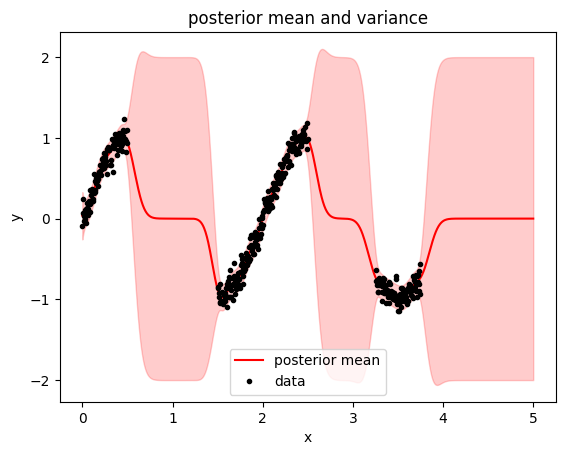

In [17]:
# plot the beta
# plt.plot(x, train_posterior['mean'], 'r-', label='posterior mean')
plt.plot(x, ytrg['mean'], 'r-', label='posterior mean')
# shaded region for +- 2 std
plt.fill_between(x, ytrg['mean'] - 2 * torch.sqrt(ytrg['var']), ytrg['mean'] + 2 * torch.sqrt(ytrg['var']), color='r', alpha=0.2)
plt.plot(x_input, y_input, 'k.', label='data')
plt.xlabel('x')
plt.ylabel('y')
plt.title('posterior mean and variance')
plt.legend()
plt.show()

In [18]:
# the outputs you get here, for example F, are for the subset of points x_input, not the full x
beta_cg, xis_cg, ytrg_cg, A_cg, F_cg, ws_cg, timing_results_cg = efgp1d_dense(x_input, y_input, sigmasq=torch.tensor(0.1), kernel=kernel, eps=EPSILON, x_new=x, opts={'get_var': True, 'method': 'cg', 'get_log_marginal_likelihood': True})


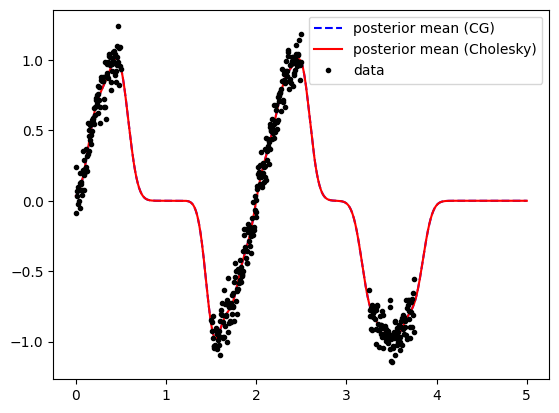

In [19]:
plt.plot(x, ytrg_cg['mean'], 'b--', label='posterior mean (CG)')
plt.plot(x, ytrg['mean'], 'r-', label='posterior mean (Cholesky)')
# plt.fill_between(x, ytrg_cg['mean'] - 2 * torch.sqrt(ytrg_cg['var']), ytrg_cg['mean'] + 2 * torch.sqrt(ytrg_cg['var']), color='b', alpha=0.2)
plt.plot(x_input, y_input, 'k.', label='data')
plt.legend()
plt.show()


In [20]:
assert torch.allclose(ytrg_cg['mean'], ytrg['mean'], atol=1e-8), "ytrg_cg['mean'] and ytrg['mean'] are not the same"

# CG FFT implementation

In [21]:
from efgp1d import efgp1d
beta_fft_cg, xis_fft_cg, ytrg_fft_cg, timing_results_fft_cg = efgp1d(x_input, y_input, sigmasq=torch.tensor(0.1), kernel=kernel, eps=EPSILON, x_new=x, opts={'get_var': True, 'get_log_marginal_likelihood': True})



/Users/colecitrenbaum/myenv/lib/python3.13/site-packages/torch/autograd/profiler.py:266: UserWarning: CUDA is not available, disabling CUDA profiling
  warn("CUDA is not available, disabling CUDA profiling")


ValueError: not enough values to unpack (expected 4, got 3)

In [ ]:
beta_fft_cg


tensor([-1.4179e-03+7.0671e-04j,  1.6427e-04-1.8294e-03j,
        -5.5157e-03-5.0039e-03j,  2.5622e-03+6.2274e-03j,
        -7.7507e-03-9.1929e-03j, -3.6290e-03+2.3697e-03j,
        -4.9957e-04+5.7253e-03j, -1.2786e-02-4.7904e-03j,
         8.6269e-03-4.7641e-03j, -3.2230e-02+2.3542e-02j,
         2.5407e-02-3.4875e-03j, -1.1199e-02-1.9617e-02j,
        -4.0987e-02+6.1586e-02j,  6.1013e-02-3.0048e-02j,
        -1.5241e-02+9.8715e-03j, -3.6491e-02+1.0942e-02j,
         5.0887e-02+1.0935e-02j,  5.0185e-02-1.3669e-02j,
        -1.1968e-01-5.9442e-02j,  9.0640e-02+7.4055e-02j,
        -2.5561e-03-6.5749e-02j, -9.9477e-02-1.8595e-02j,
         6.8073e-02+1.0842e-02j, -7.8933e-02+5.4213e-02j,
         5.0759e-02-5.5474e-02j, -1.4065e-02+6.3534e-03j,
        -1.1118e-02+3.2298e-02j,  1.8775e-02-5.0948e-02j,
         5.0187e-02-2.9640e-02j, -8.3043e-02-1.0055e-01j,
        -6.0547e-02+4.5017e-02j, -3.0845e-02-7.9070e-02j,
        -1.5784e-02+5.2940e-02j, -1.5180e-01-4.0625e-02j,
        -2.225

In [ ]:
ws

tensor([1.2526e-04, 1.7022e-04, 2.2983e-04, 3.0832e-04, 4.1095e-04, 5.4421e-04,
        7.1605e-04, 9.3609e-04, 1.2159e-03, 1.5691e-03, 2.0119e-03, 2.5631e-03,
        3.2443e-03, 4.0801e-03, 5.0981e-03, 6.3292e-03, 7.8070e-03, 9.5679e-03,
        1.1650e-02, 1.4095e-02, 1.6943e-02, 2.0235e-02, 2.4011e-02, 2.8308e-02,
        3.3160e-02, 3.8594e-02, 4.4628e-02, 5.1274e-02, 5.8531e-02, 6.6384e-02,
        7.4807e-02, 8.3756e-02, 9.3172e-02, 1.0298e-01, 1.1309e-01, 1.2339e-01,
        1.3376e-01, 1.4407e-01, 1.5417e-01, 1.6393e-01, 1.7317e-01, 1.8177e-01,
        1.8956e-01, 1.9641e-01, 2.0220e-01, 2.0682e-01, 2.1019e-01, 2.1223e-01,
        2.1292e-01, 2.1223e-01, 2.1019e-01, 2.0682e-01, 2.0220e-01, 1.9641e-01,
        1.8956e-01, 1.8177e-01, 1.7317e-01, 1.6393e-01, 1.5417e-01, 1.4407e-01,
        1.3376e-01, 1.2339e-01, 1.1309e-01, 1.0298e-01, 9.3172e-02, 8.3756e-02,
        7.4807e-02, 6.6384e-02, 5.8531e-02, 5.1274e-02, 4.4628e-02, 3.8594e-02,
        3.3160e-02, 2.8308e-02, 2.4011e-

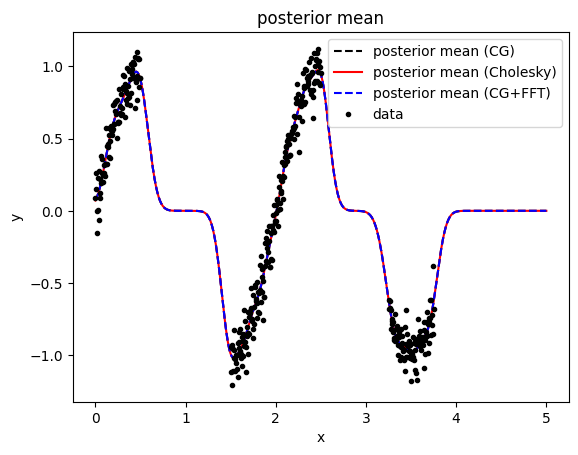

In [ ]:
plt.plot(x, ytrg_cg['mean'], 'k--', label='posterior mean (CG)')
plt.plot(x, ytrg['mean'], 'r-', label='posterior mean (Cholesky)')
plt.plot(x, ytrg_fft_cg['mean'], 'b--', label='posterior mean (CG+FFT)')
# plt.fill_between(x, ytrg_cg['mean'] - 2 * torch.sqrt(ytrg_cg['var']), ytrg_cg['mean'] + 2 * torch.sqrt(ytrg_cg['var']), color='b', alpha=0.2)
plt.plot(x_input, y_input, 'k.', label='data')
plt.xlabel('x')
plt.ylabel('y')
plt.title('posterior mean')
plt.legend()
plt.show()


In [ ]:
assert torch.allclose(ytrg_cg['mean'], ytrg_fft_cg['mean'], atol=1e-12), "ytrg_cg['mean'] and ytrg_fft_cg['mean'] are not the same"
assert torch.allclose(ytrg['mean'], ytrg_fft_cg['mean'], atol=1e-10), "ytrg['mean'] and ytrg_fft_cg['mean'] are not the same"
# the lower one has worse precision because of the device handling in cg.py


In [ ]:
# solve the N dimensional vanilla system 
from vanilla_gp_1d_dense import vanilla_gp_dense
alpha, ytrg_vanilla, timing_results_vanilla = vanilla_gp_dense(x_input, y_input, sigmasq=torch.tensor(0.1), kernel=kernel, x_new=x, opts={'get_var': False, 'method': 'cholesky', 'get_log_marginal_likelihood': True})

# same for the cg method 
alpha_cg, ytrg_cg_vanilla, timing_results_cg_vanilla = vanilla_gp_dense(x_input, y_input, sigmasq=torch.tensor(0.1), kernel=kernel, x_new=x, opts={'get_var': False, 'method': 'cg', 'get_log_marginal_likelihood': True})


Using torch.float64 precision for CG matrix-vector products!
Residual norm too small, stopping at iteration 56


In [ ]:
assert torch.allclose(ytrg['mean'], ytrg_vanilla['mean'], atol=1e-6), "ytrg['mean'] and ytrg_vanilla['mean'] are not the same"
assert torch.allclose(ytrg_cg['mean'], ytrg_cg_vanilla['mean'], atol=1e-6), "ytrg_cg['mean'] and ytrg_cg_vanilla['mean'] are not the same"

AssertionError: ytrg['mean'] and ytrg_vanilla['mean'] are not the same

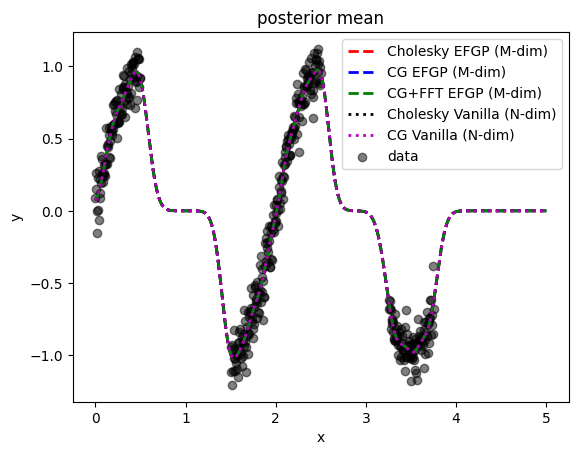

In [ ]:
# plot all the lines on the same plot
plt.plot(x, ytrg['mean'], 'r--', label='Cholesky EFGP (M-dim)', linewidth=2)
plt.plot(x, ytrg_cg['mean'], 'b--', label='CG EFGP (M-dim)', linewidth=2)
plt.plot(x, ytrg_fft_cg['mean'], 'g--', label='CG+FFT EFGP (M-dim)', linewidth=2)
plt.plot(x, ytrg_vanilla['mean'], 'k', label='Cholesky Vanilla (N-dim)', linestyle="dotted", linewidth=2)
plt.plot(x, ytrg_cg_vanilla['mean'], 'm', label='CG Vanilla (N-dim)', linestyle="dotted", linewidth=2)
plt.scatter(x_input, y_input, color='k', label='data', alpha=0.5)
plt.xlabel('x')
plt.ylabel('y')
plt.title('posterior mean')
plt.legend()
plt.show()


In [ ]:
ytrg_vanilla.keys()

dict_keys(['mean', 'log_marginal_likelihood'])

In [ ]:
# compare log marginal likelihoods
assert torch.allclose(ytrg_vanilla['log_marginal_likelihood'], ytrg_cg_vanilla['log_marginal_likelihood'], atol=1e-16), "ytrg_vanilla['log_marginal_likelihood'] and ytrg_cg_vanilla['log_marginal_likelihood'] are not the same"


In [ ]:
assert torch.allclose(ytrg_fft_cg['log_marginal_likelihood'], ytrg_cg_vanilla['log_marginal_likelihood'], atol=1e-16), "ytrg_fft_cg['log_marginal_likelihood'] and ytrg_cg_vanilla['log_marginal_likelihood'] are not the same"

In [ ]:
# print the five log marginal likelihoods
print("log marginal likelihoods:")
print("vanilla: ", ytrg_vanilla['log_marginal_likelihood'])
print("cg vanilla: ", ytrg_cg_vanilla['log_marginal_likelihood'])
print("efgp cg: ", ytrg_cg['log_marginal_likelihood'])
print("efgp cg fft: ", ytrg_fft_cg['log_marginal_likelihood'])
print("efgp dense: ", ytrg['log_marginal_likelihood'])


log marginal likelihoods:
vanilla:  tensor(17.0927, dtype=torch.float64)
cg vanilla:  tensor(17.0927, dtype=torch.float64)
efgp cg:  tensor(17.0928, dtype=torch.float64)
efgp cg fft:  tensor(17.0928, dtype=torch.float64)
efgp dense:  tensor(17.0928, dtype=torch.float64)


In [ ]:
assert torch.allclose(ytrg_vanilla['log_marginal_likelihood'], ytrg_cg_vanilla['log_marginal_likelihood'], atol=1e-16), "ytrg_vanilla['log_marginal_likelihood'] and ytrg_cg_vanilla['log_marginal_likelihood'] are not the same"
assert torch.allclose(ytrg_cg['log_marginal_likelihood'], ytrg_fft_cg['log_marginal_likelihood'], atol=1e-16), "ytrg_cg['log_marginal_likelihood'] and ytrg_fft_cg['log_marginal_likelihood'] are not the same"
assert torch.allclose(ytrg['log_marginal_likelihood'], ytrg_fft_cg['log_marginal_likelihood'], atol=1e-16), "ytrg['log_marginal_likelihood'] and ytrg_fft_cg['log_marginal_likelihood'] are not the same"
assert torch.allclose(ytrg['log_marginal_likelihood'], ytrg_cg['log_marginal_likelihood'], atol=1e-16), "ytrg['log_marginal_likelihood'] and ytrg_cg['log_marginal_likelihood'] are not the same"
assert torch.allclose(ytrg['log_marginal_likelihood'], ytrg_fft_cg['log_marginal_likelihood'], atol=1e-16), "ytrg['log_marginal_likelihood'] and ytrg_fft_cg['log_marginal_likelihood'] are not the same"


In [ ]:
timing_dicts = [timing_results, timing_results_cg, timing_results_fft_cg]
# loop over the timing dicts and add a column for the method
for i, timing_dict in enumerate(timing_dicts):
    timing_dict['method'] = ['dense', 'cg', 'cg+fft'][i]
# make a dataframe
import pandas as pd
df = pd.DataFrame(timing_dicts)
df


,rhs_time,construct_system_time,solve_time,method
0,0.000988,0.000515,0.000583,dense
1,0.001153,0.000582,0.004730,cg
2,0.000560,0.000666,0.008096,cg+fft


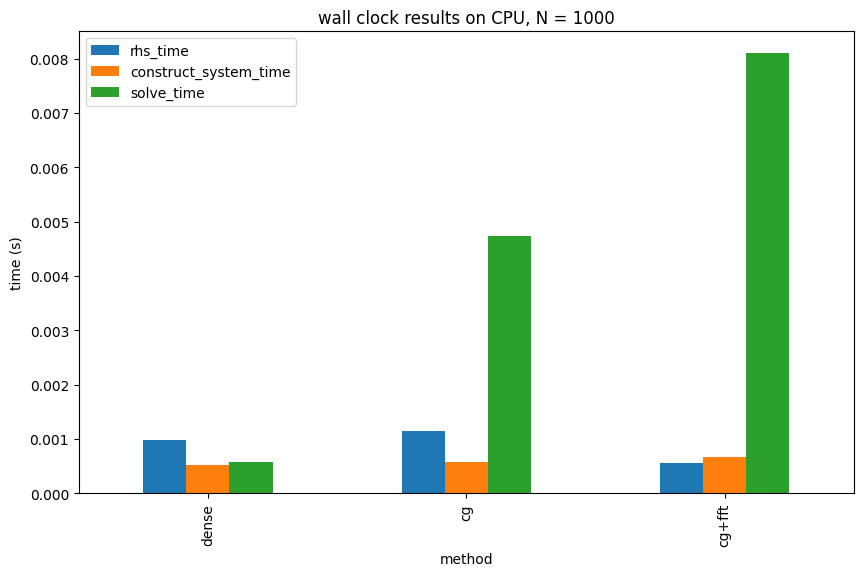

In [ ]:
# plot the timing results (method in color, other columns on x axis)
df.plot(x='method', y=['rhs_time', 'construct_system_time', 'solve_time'], kind='bar', figsize=(10, 6))
plt.xlabel('method')
plt.ylabel('time (s)')
plt.title(f'wall clock results on CPU, N = {N}')
plt.show()


## exploring the effects of tolerance on estimating the log marginal likelihood 

In [ ]:
epsilons = torch.logspace(-16, -2, 14)
epsilons

tensor([1.0000e-16, 1.1938e-15, 1.4251e-14, 1.7013e-13, 2.0309e-12, 2.4245e-11,
        2.8943e-10, 3.4551e-09, 4.1246e-08, 4.9239e-07, 5.8780e-06, 7.0170e-05,
        8.3768e-04, 1.0000e-02])

In [ ]:
log_marginal_likelihoods = []
for epsilon in epsilons:
    beta_fft_cg, xis_fft_cg, ytrg_fft_cg, timing_results_fft_cg = efgp1d(x_input, y_input, sigmasq=torch.tensor(0.1), kernel=kernel, eps=epsilon, x_new=x, opts={'get_var': True, 'get_log_marginal_likelihood': True})
    print("--------------------------------")
    print(f"epsilon: {epsilon}, num nodes: {len(xis_fft_cg)}, log marginal likelihood: {ytrg_fft_cg['log_marginal_likelihood']}")
    log_marginal_likelihoods.append(ytrg_fft_cg['log_marginal_likelihood'])


Using torch.complex128 precision for CG matrix-vector products!
Residual norm too small, stopping at iteration 54
--------------------------------
epsilon: 1.0000000168623835e-16, num nodes: 169, log marginal likelihood: 17.092746273837918
Using torch.complex128 precision for CG matrix-vector products!
Residual norm too small, stopping at iteration 54
--------------------------------
epsilon: 1.1937766838829257e-15, num nodes: 163, log marginal likelihood: 17.092746271843282
Using torch.complex128 precision for CG matrix-vector products!
Residual norm too small, stopping at iteration 54
--------------------------------
epsilon: 1.4251026099758486e-14, num nodes: 157, log marginal likelihood: 17.092746274539365
Using torch.complex128 precision for CG matrix-vector products!
Residual norm too small, stopping at iteration 54
--------------------------------
epsilon: 1.7012542904374511e-13, num nodes: 151, log marginal likelihood: 17.09274624894141
Using torch.complex128 precision for CG m

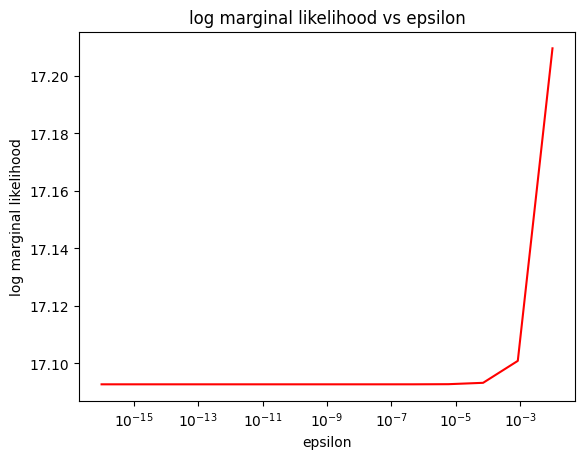

In [ ]:
plt.plot(epsilons, log_marginal_likelihoods, 'r-')
plt.xscale('log')
plt.xlabel('epsilon')
plt.ylabel('log marginal likelihood')
plt.title('log marginal likelihood vs epsilon')
plt.show()


# Convolution implementation

first, with a toy example, we construct a Toeplitz matrix and corresponding discrete convolution vector. We verify that the results match.
We do the causal case first just to ensure that the implementation is correct.

In [ ]:
import torch
import torch.nn.functional as F

# Set m to define signal lengths
m = 5

# Create tensors v and b with different lengths
v = torch.arange(4 * m + 1, dtype=torch.float32)  # Signal v of length 4*m + 1
b = torch.arange(2 * m + 1, dtype=torch.float32)  # Signal b of length 2*m + 1

# ===== Discrete Convolution =====

# Reshape v to (batch_size=1, in_channels=1, length)
v_reshaped = v.unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, len_v)

# Flip b for convolution (conv1d performs cross-correlation by default)
b_flipped = b.flip(0).unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, len_b)

# Perform discrete convolution
conv_output = F.conv1d(v_reshaped, b_flipped).squeeze()  # Shape: (output_length,)

def elementwise_valid_conv(v: torch.Tensor, b: torch.Tensor) -> torch.Tensor:
    len_v = len(v)
    len_b = len(b)
    conv_length = len_v + len_b - 1  # Full convolution length

    # Find next power of two for efficient FFT computation
    fft_length = 1 << (conv_length - 1).bit_length()

    # Pad signals to fft_length
    v_padded = F.pad(v, (0, fft_length - len_v))
    b_padded = F.pad(b, (0, fft_length - len_b))

    # Compute FFTs of padded signals
    V = torch.fft.fft(v_padded)
    B = torch.fft.fft(b_padded)

    # Multiply in the frequency domain
    conv_fft = V * B

    # Compute inverse FFT to get convolution result
    conv_result_full = torch.fft.ifft(conv_fft).real

    # Extract the valid part of the convolution result
    valid_length = len_v - len_b + 1
    start = len_b - 1
    end = start + valid_length
    return conv_result_full[start:end]

# ===== Display Results =====

print("Discrete convolution output:")
print(conv_output)

print("\nFFT convolution valid part:")
print(conv_valid)

# Verify that both methods yield similar results
print("\nDifference between discrete convolution and FFT convolution:")
print(torch.abs(conv_output - conv_valid))

print("\nAre the results close? ", torch.allclose(conv_output, conv_valid))


Discrete convolution output:
tensor([165., 220., 275., 330., 385., 440., 495., 550., 605., 660., 715.])

FFT convolution valid part:
tensor([165.0000, 220.0000, 275.0000, 330.0000, 384.9999, 440.0000, 495.0000,
        550.0000, 605.0000, 660.0000, 715.0000])

Difference between discrete convolution and FFT convolution:
tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 6.1035e-05, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00])

Are the results close?  True


In [ ]:
class FFTConv1d:
    def __init__(self, v, b):
        self.v = v
        self.b = b
        self.len_v = len(v)
        self.len_b = len(b)
        self.conv_length = self.len_v + self.len_b - 1  # Full convolution length
        self.valid_length = self.len_v - self.len_b + 1  # = 4m+1 - (2m+1) + 1 = 2m + 1
        self.start = self.len_b - 1  # = 2m + 1 - 1 = 2m
        self.end = self.start + self.valid_length  # = 2m + 2m + 1 = 4m + 1

    def pad_right(self):
        # Find next power of two for efficient FFT computation
        fft_length = 1 << (self.conv_length - 1).bit_length()
        # Pad signals to fft_length (padding with zeros at the right)
        v_padded = F.pad(self.v, (0, fft_length - self.len_v))
        b_padded = F.pad(self.b, (0, fft_length - self.len_b))
        return v_padded, b_padded

    def fft_multiply_ifft(self, v_padded, b_padded):
        # Compute FFTs of padded signals
        V = torch.fft.fft(v_padded)
        B = torch.fft.fft(b_padded)
        # Multiply in the frequency domain
        conv_fft = V * B
        # Compute inverse FFT to get convolution result
        return torch.fft.ifft(conv_fft)

    def extract_valid(self, conv_result_full):
        # Extract the valid part of the convolution result
        return conv_result_full[self.start:self.end]  # = conv_result_full[2m:4m+1]

    def __call__(self):
        v_padded, b_padded = self.pad_right()
        conv_result_full = self.fft_multiply_ifft(v_padded, b_padded)
        return self.extract_valid(conv_result_full)

# fft_conv = FFTConv1d(v, b)
# conv_valid = fft_conv()


In [ ]:
import torch
import torch.nn.functional as F

# Set m to define signal lengths
# assume that mtot = M = 2m + 1
m = 5

# Create random tensors v and b with different lengths
v = torch.randn(4 * m + 1, dtype=torch.float64)  # Signal v of length 4*m + 1
b = torch.randn(2 * m + 1, dtype=torch.float64)  # Signal b of length 2*m + 1

# ===== Discrete Convolution =====

# Reshape v to (batch_size=1, in_channels=1, length)
v_reshaped = v.unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, len_v)

# Flip b for convolution (conv1d performs cross-correlation by default)
b_flipped = b.flip(0).unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, len_b)

# Perform discrete convolution
conv_output = F.conv1d(v_reshaped, b_flipped).squeeze()  # Shape: (output_length,)

# ===== Convolution Using FFT =====
len_v = len(v)
len_b = len(b)
conv_length = len_v + len_b - 1  # Full convolution length

# Find next power of two for efficient FFT computation
fft_length = 1 << (conv_length - 1).bit_length()

# Pad signals to fft_length (padding with zeros at the right, unlike the paper which does the left)
v_padded = F.pad(v, (0, fft_length - len_v))
b_padded = F.pad(b, (0, fft_length - len_b))

# Compute FFTs of padded signals
V = torch.fft.fft(v_padded)
B = torch.fft.fft(b_padded)

# Multiply in the frequency domain
conv_fft = V * B

# Compute inverse FFT to get convolution result
conv_result_full = torch.fft.ifft(conv_fft)

# Extract the valid part of the convolution result
valid_length = len_v - len_b + 1 # = 4m+1 - (2m+1) + 1 = 2m + 1
start = len_b - 1 # = 2m + 1 - 1 = 2m
end = start + valid_length # = 2m + 2m + 1 = 4m + 1
conv_valid = conv_result_full[start:end] # = conv_result_full[2m:4m+1]

# ===== Convolution Using Toeplitz Matrix (via unfold) =====

# Flip b for convolution
b_flipped = b.flip(0)  # Shape: (len_b,)

# Compute output length
output_length = len_v - len_b + 1

# Use unfold to extract sliding windows from v
v_unfolded = v.unfold(0, len_b, 1)  # Shape: (output_length, len_b)

# Compute the convolution via matrix multiplication
conv_toeplitz_unfold = v_unfolded @ b_flipped  # Shape: (output_length,)

# ===== Convolution Using Explicit Toeplitz Matrix =====

# Initialize Toeplitz matrix T
T = torch.zeros((output_length, len_v), dtype=torch.float32)

# Construct Toeplitz matrix
for i in range(output_length):
    T[i, i:i+len_b] = b_flipped

# Perform convolution via matrix multiplication
conv_toeplitz_explicit = T @ v  # Shape: (output_length,)

# ===== Display Results =====

print("Discrete convolution output:")
print(conv_output)

print("\nFFT convolution valid part:")
print(conv_valid)

print("\nConvolution via Toeplitz matrix (using unfold):")
print(conv_toeplitz_unfold)

print("\nConvolution via explicit Toeplitz matrix:")
print(conv_toeplitz_explicit)

# Verify that all methods yield similar results
print("\nDifference between discrete convolution and Toeplitz convolution (unfold):")
print(torch.abs(conv_output - conv_toeplitz_unfold))

print("\nDifference between discrete convolution and explicit Toeplitz convolution:")
print(torch.abs(conv_output - conv_toeplitz_explicit))

print("\nAre the discrete convolution and Toeplitz convolution (unfold) results close? ", torch.allclose(conv_output, conv_toeplitz_unfold))

print("Are the discrete convolution and explicit Toeplitz convolution results close? ", torch.allclose(conv_output, conv_toeplitz_explicit))


RuntimeError: expected scalar type Float but found Double

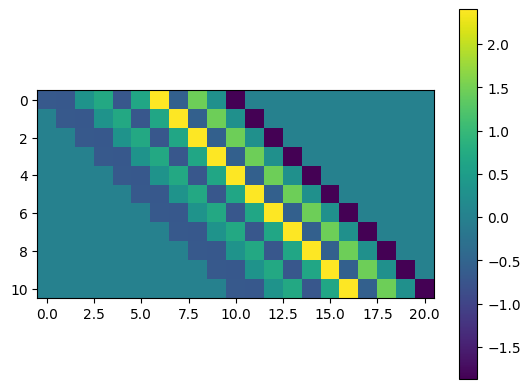

In [ ]:
plt.imshow(T)
plt.colorbar()
plt.show()


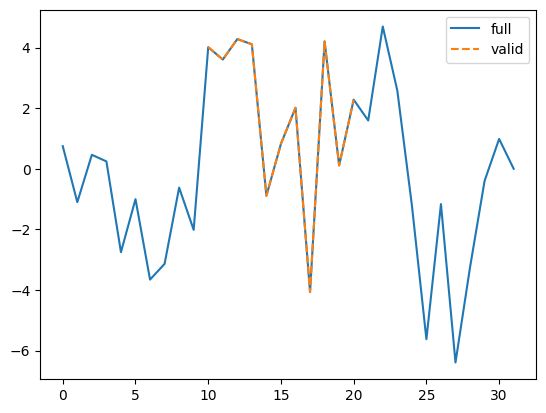

In [ ]:
# plot the full and valid convolution outputs from fft
# full
plt.plot(conv_result_full.real, label='full')
# valid at the right x indices
plt.plot(torch.arange(2*m, 4*m+1), conv_valid.real, linestyle='--', label='valid')
plt.legend()
plt.show()


In [ ]:
def compute_valid_convolution(v: torch.Tensor, b: torch.Tensor) -> torch.Tensor:
    # Extract m from input sizes
    size_v = v.shape[0]
    size_b = b.shape[0]
    
    # size_v should be 4m+1 for some integer m
    # size_b should be 2m+1 for the same m
    assert (size_v - 1) % 4 == 0, "v must have size 4m+1 for some integer m"
    m = (size_v - 1) // 4
    assert size_b == 2*m + 1, "b must have size 2m+1 where m is derived from v's size"

    # Pad the vector b to resize to size_v
    b_padded = torch.zeros(size_v, dtype=torch.complex128)
    b_padded[:size_b] = b  # Pad with zeros at the end

    # Compute the convolution via FFTs
    # The length of the convolution output is L = N + M - 1
    L = size_v + size_b - 1

    # Pad both v and b_padded to length L
    v_padded = torch.zeros(L, dtype=torch.complex128)
    v_padded[:size_v] = v

    b_padded_L = torch.zeros(L, dtype=torch.complex128)
    b_padded_L[:size_b] = b

    # Compute FFTs of the padded vectors
    V_fft = torch.fft.fft(v_padded)
    B_fft = torch.fft.fft(b_padded_L)

    # Perform element-wise multiplication in the frequency domain
    Y_fft = V_fft * B_fft

    # Compute the inverse FFT to get the convolution result
    y_conv = torch.fft.ifft(Y_fft)

    # Extract the valid elements (2m+1 elements) from the convolution result
    # The valid convolution output corresponds to indices from size_b - 1 to size_v
    y_valid = y_conv[size_b - 1:size_v]
    
    return y_valid

In [ ]:
def compute_convolution_vector(m: int, x: torch.Tensor, h: float) -> torch.Tensor:
    """
    NOTE: this gives issues with precision, use compute_convolution_vector_vectorized instead.
    Compute convolution vector v where v[j] = sum_n exp(2πihjxₙ) for j in [-2m,2m]
    
    Args:
        m (int): Half number of nodes (mtot = 2m + 1)
        x (torch.Tensor): Input points
        h (float): Grid spacing
        
    Returns:
        torch.Tensor: Convolution vector of shape (4m+1,)
    """
    # j ranges from -2m to 2m inclusive
    j_indices = torch.arange(-2*m, 2*m + 1, dtype=torch.float64)
    
    # For each j, compute sum_n exp(2πihjxₙ)
    v = torch.zeros((4*m + 1,), dtype=torch.complex128)
    for idx, j in enumerate(j_indices):
        v[idx] = torch.sum(torch.exp(2 * torch.pi * 1j * h * j * x))
    return v, j_indices


In [ ]:
v, j_indices = compute_convolution_vector(m=int((mtot - 1) / 2), x=x, h=h)

In [ ]:
m = int((mtot - 1) / 2)
assert v.shape[0] == 4*m + 1, "v should have length 4m + 1"

plt.plot(j_indices, v.real, label=r'$\Re(v)$', linewidth=2)
plt.plot(j_indices, v.imag, label=r'$\Im(v)$', linewidth=2)
plt.legend()
plt.xlabel(r'$j = -2m, \ldots, 2m$')
plt.ylabel(r'$v_j$')
plt.title(r'Convolution vector $v \in \mathbb{C}^{4m+1}$')
plt.show()

AssertionError: v should have length 4m + 1

In [ ]:
v_hat = torch.fft.fft(v)
assert v_hat.shape[0] == 4*m + 1, "v_hat should have length 4m + 1"

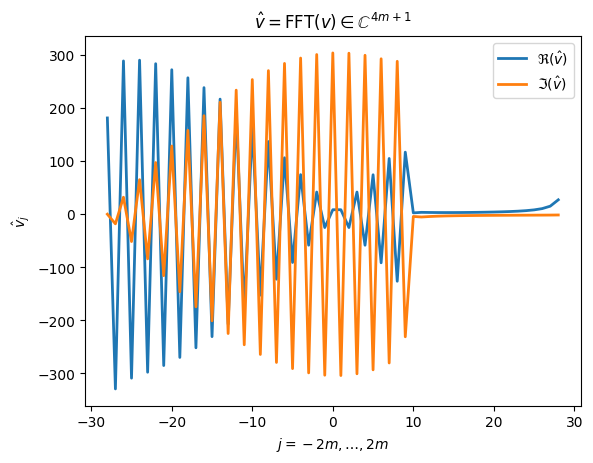

In [ ]:
# plot v_hat
plt.plot(j_indices, v_hat.real, label=r'$\Re(\hat{v})$', linewidth=2)
plt.plot(j_indices, v_hat.imag, label=r'$\Im(\hat{v})$', linewidth=2)
plt.legend()
plt.xlabel(r'$j = -2m, \ldots, 2m$')
plt.ylabel(r'$\hat{v}_j$')
plt.title(r'$\hat{v} = \text{FFT}(v) \in \mathbb{C}^{4m+1}$')
plt.show()

In [ ]:
# generate data 
N = 200
freq = 2    
x = torch.linspace(0, 1, N)
y = torch.sin(2 * torch.pi * freq * x) + torch.randn(N) * 0.1


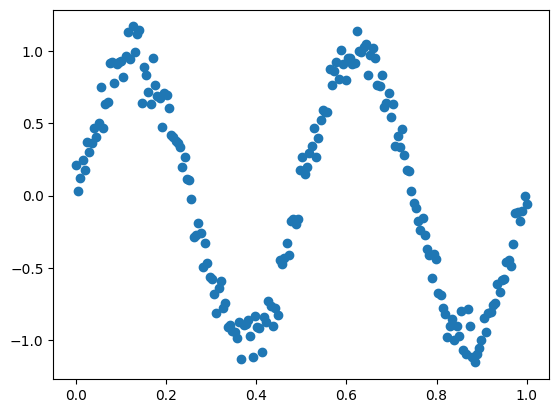

In [ ]:
plt.scatter(x, y)
plt.show()


In [ ]:
def compute_convolution_vector_vectorized(m: int, x: torch.Tensor, h: float) -> torch.Tensor:
    """
    Vectorized implementation of compute_convolution_vector
    Args:
        m (int): Half number of nodes (mtot = 2m + 1)
        x (torch.Tensor): Input points
        h (float): Grid spacing
    Returns:
        torch.Tensor: Convolution vector of shape (4m+1,)
    """
    j_indices = torch.arange(-2*m, 2*m + 1, dtype=torch.float64) # j = -2m, ..., 2m
    exponents = 2 * torch.pi * 1j * h * torch.outer(j_indices, x)
    v = torch.sum(torch.exp(exponents), dim=1)
    return v, j_indices



Compare
$$
F^*F b = \text{IFFT}(\text{FFT}(v) \odot \text{FFT}(b))
$$


In [ ]:
import torch
import torch.nn.functional as F

# Set m to define signal lengths
# assume that mtot = M = 2m + 1
m = 5

# Create random tensors v and b with different lengths
v = torch.randn(4 * m + 1, dtype=torch.float64)  # Signal v of length 4*m + 1
b = torch.randn(2 * m + 1, dtype=torch.float64)  # Signal b of length 2*m + 1

# ===== Discrete Convolution =====

# Reshape v to (batch_size=1, in_channels=1, length)
v_reshaped = v.unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, len_v)

# Flip b for convolution (conv1d performs cross-correlation by default)
b_flipped = b.flip(0).unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, len_b)

# Perform discrete convolution
conv_output = F.conv1d(v_reshaped, b_flipped).squeeze()  # Shape: (output_length,)

# ===== Convolution Using FFT =====
len_v = len(v)
len_b = len(b)
conv_length = len_v + len_b - 1  # Full convolution length

# Find next power of two for efficient FFT computation
fft_length = 1 << (conv_length - 1).bit_length()

# Pad signals to fft_length (padding with zeros at the right, unlike the paper which does the left)
v_padded = F.pad(v, (0, fft_length - len_v))
b_padded = F.pad(b, (0, fft_length - len_b))

# Compute FFTs of padded signals
V = torch.fft.fft(v_padded)
B = torch.fft.fft(b_padded)

# Multiply in the frequency domain
conv_fft = V * B

# Compute inverse FFT to get convolution result
conv_result_full = torch.fft.ifft(conv_fft)

# Extract the valid part of the convolution result
valid_length = len_v - len_b + 1 # = 4m+1 - (2m+1) + 1 = 2m + 1
start = len_b - 1 # = 2m + 1 - 1 = 2m
end = start + valid_length # = 2m + 2m + 1 = 4m + 1
conv_valid = conv_result_full[start:end] # = conv_result_full[2m:4m+1]

# ===== Convolution Using Toeplitz Matrix (via unfold) =====

# Flip b for convolution
b_flipped = b.flip(0)  # Shape: (len_b,)

# Compute output length
output_length = len_v - len_b + 1

# Use unfold to extract sliding windows from v
v_unfolded = v.unfold(0, len_b, 1)  # Shape: (output_length, len_b)

# Compute the convolution via matrix multiplication
conv_toeplitz_unfold = v_unfolded @ b_flipped  # Shape: (output_length,)

# ===== Convolution Using Explicit Toeplitz Matrix =====

# Initialize Toeplitz matrix T
T = torch.zeros((output_length, len_v), dtype=torch.float32)

# Construct Toeplitz matrix
for i in range(output_length):
    T[i, i:i+len_b] = b_flipped

# Perform convolution via matrix multiplication
conv_toeplitz_explicit = T @ v  # Shape: (output_length,)

# ===== Display Results =====

print("Discrete convolution output:")
print(conv_output)

print("\nFFT convolution valid part:")
print(conv_valid)

print("\nConvolution via Toeplitz matrix (using unfold):")
print(conv_toeplitz_unfold)

print("\nConvolution via explicit Toeplitz matrix:")
print(conv_toeplitz_explicit)

# Verify that all methods yield similar results
print("\nDifference between discrete convolution and Toeplitz convolution (unfold):")
print(torch.abs(conv_output - conv_toeplitz_unfold))

print("\nDifference between discrete convolution and explicit Toeplitz convolution:")
print(torch.abs(conv_output - conv_toeplitz_explicit))

print("\nAre the discrete convolution and Toeplitz convolution (unfold) results close? ", torch.allclose(conv_output, conv_toeplitz_unfold))

print("Are the discrete convolution and explicit Toeplitz convolution results close? ", torch.allclose(conv_output, conv_toeplitz_explicit))


In [ ]:
# need to form the Toeplitz matrix F^*F (eqn. 19)
# need to construct the convolution vector v (eqn. 20)
# build a random vector size 2m+1
# assert that the two methods for convolution give the same result


In [ ]:
# form a convolution vector v
N = len(x)
j_indices = torch.arange(-2*m, 2*m + 1, dtype=torch.float64)
assert j_indices.shape[0] == 4*m + 1, "j_indices should have length 4m + 1"

# Outer product of j_indices and x
exponents = 2 * torch.pi * 1j * h * torch.outer(j_indices, x)
v_second_approach = torch.sum(torch.exp(exponents), dim=1)
assert v_second_approach.shape[0] == 4*m + 1, "v_second_approach should have length 4m + 1"

In [ ]:
# assert torch.allclose(v.to(dtype=torch.complex128), v_second_approach.to(dtype=torch.complex128), rtol=1e-5, atol=1e-4), "v and v_second_approach are not the same"


In [ ]:
class FFTConv1d:
    def __init__(self, v, b):
        self.v = v
        self.b = b
        self.len_v = len(v)
        self.len_b = len(b)
        self.conv_length = self.len_v + self.len_b - 1  # Full convolution length
        self.valid_length = self.len_v - self.len_b + 1  # = 4m+1 - (2m+1) + 1 = 2m + 1
        self.start = self.len_b - 1  # = 2m + 1 - 1 = 2m
        self.end = self.start + self.valid_length  # = 2m + 2m + 1 = 4m + 1

    def pad_right(self):
        # Find next power of two for efficient FFT computation
        fft_length = 1 << (self.conv_length - 1).bit_length()
        # Pad signals to fft_length (padding with zeros at the right)
        v_padded = torch.nn.functional.pad(self.v, (0, fft_length - self.len_v))
        b_padded = torch.nn.functional.pad(self.b, (0, fft_length - self.len_b))
        return v_padded, b_padded

    def fft_multiply_ifft(self, v_padded, b_padded):
        # Compute FFTs of padded signals
        V = torch.fft.fft(v_padded)
        B = torch.fft.fft(b_padded)
        # Multiply in the frequency domain
        conv_fft = V * B
        # Compute inverse FFT to get convolution result
        return torch.fft.ifft(conv_fft)

    def extract_valid(self, conv_result_full):
        # Extract the valid part of the convolution result
        return conv_result_full[self.start:self.end]  # = conv_result_full[2m:4m+1]

    def __call__(self):
        v_padded, b_padded = self.pad_right()
        conv_result_full = self.fft_multiply_ifft(v_padded, b_padded)
        return self.extract_valid(conv_result_full)

# fft_conv = FFTConv1d(v, b)
# conv_valid = fft_conv()


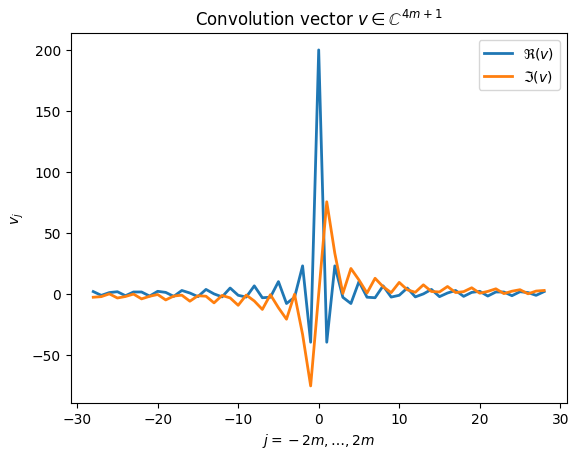

In [ ]:
plt.plot(j_indices, v_second_approach.real, label=r'$\Re(v)$', linewidth=2)
# plt.plot(j_indices, v.real, label=r'$\Re(v)$', linewidth=2)
plt.plot(j_indices, v_second_approach.imag, label=r'$\Im(v)$', linewidth=2)
# plt.plot(j_indices, v.imag, label=r'$\Im(v)$', linewidth=2)
plt.legend()
plt.xlabel(r'$j = -2m, \ldots, 2m$')
plt.ylabel(r'$v_j$')
plt.title(r'Convolution vector $v \in \mathbb{C}^{4m+1}$')
plt.show()


# Debug with Philip

In [ ]:
# generate data 
N = 200
freq = 2    
x = torch.linspace(0, 1, N)
y = torch.sin(2 * torch.pi * freq * x) + torch.randn(N) * 0.1

In [ ]:
# Determine problem geometry
L = x[-1] - x[0]
N = x.shape[0]
EPSILON = 1e-5
xis, h, mtot = get_xis(kernel_obj=kernel, eps=EPSILON, L=L, use_integral=False, l2scaled=False)


In [ ]:
ws = torch.sqrt(kernel.spectral_density(xis) * h)
D = torch.diag(ws)

In [ ]:
# Form design matrix F
# We do so manually here for clarity (no FFT / NUFFT)
F = torch.exp(1j * 2 * torch.pi * torch.outer(x, xis))

In [ ]:
toeplitz_mat = F.conj().T @ F

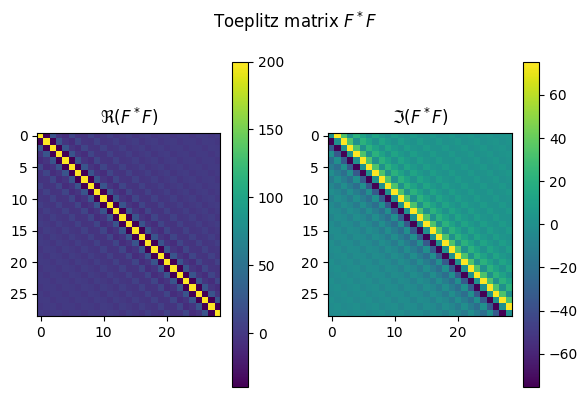

In [ ]:
# side by side toeplitz mat real and imag
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 4))
im1 = ax1.imshow(toeplitz_mat.real)
plt.colorbar(im1, ax=ax1)
ax1.set_title(r'$\Re(F^*F)$')
im2 = ax2.imshow(toeplitz_mat.imag)
plt.colorbar(im2, ax=ax2)
ax2.set_title(r'$\Im(F^*F)$')
plt.suptitle(r'Toeplitz matrix $F^*F$')
plt.tight_layout()
plt.show()


In [ ]:
random_vector = torch.randn(mtot, dtype=torch.complex128)

In [ ]:
x_input = torch.cat([x[:30], x[60:70], x[70:90]])
y_input = torch.cat([y[:30], y[60:70], y[70:90]])

In [ ]:
# dense posterior mean
# the outputs you get here, for example F, are for the subset of points x_input, not the full x
beta, xis, ytrg, A, F, ws = efgp1d_dense(x_input, y_input, sigmasq=torch.tensor(0.1), kernel=kernel, eps=EPSILON, x_new=x, opts={'get_var': True})# toeplitz times random vector

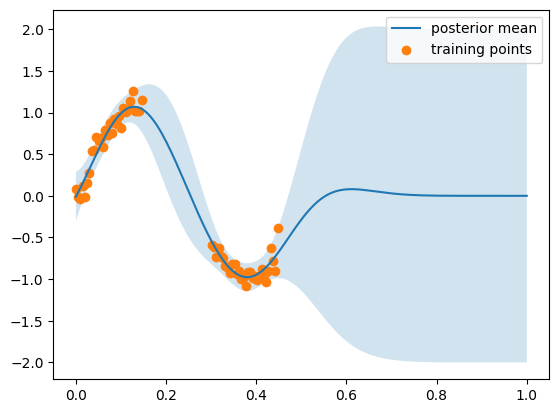

In [ ]:
plt.plot(x, ytrg["mean"].real, label="posterior mean")
# plot variance fill_between 
plt.fill_between(x, ytrg["mean"] - 2*torch.sqrt(ytrg["var"]), ytrg["mean"] + 2*torch.sqrt(ytrg["var"]), alpha=0.2)
plt.scatter(x_input, y_input, label="training points")
plt.legend()
plt.show()

In [ ]:
# Form design matrix F
# We do so manually here for clarity (no FFT / NUFFT)
# note using x_input and not x, same for y_input
D = torch.diag(ws).to(dtype=torch.complex128)
F = torch.exp(1j * 2 * torch.pi * torch.outer(x_input, xis)).to(dtype=torch.complex128)

In [ ]:
right_hand_side = D @ torch.conj(F).T @ y_input.to(dtype=torch.complex128)

In [ ]:
# F.conj() == torch.conj(F)

NameError: name 'F' is not defined

In [ ]:
toeplitz_mat = (F.conj().T @ F).to(dtype=torch.complex128)
sigma_sq = torch.tensor(0.1)
left_hand_size = D @ toeplitz_mat.to(dtype=torch.complex128) @ D + sigma_sq * torch.eye(mtot).to(dtype=torch.complex128)

In [ ]:
# solve with cholesky
chol_factor = torch.linalg.cholesky(left_hand_size)
beta_toeplitz = torch.cholesky_solve(right_hand_side.unsqueeze(-1), chol_factor).squeeze(-1)


In [ ]:
assert torch.allclose(beta_toeplitz, beta, rtol=1e-5, atol=1e-4), "beta_toeplitz and beta are not the same"

In [ ]:
v_from_toeplitz = torch.cat([toeplitz_mat[:,0].flip(0), toeplitz_mat[0,1:]]) # flipping just the first column so that 0 interval is in the middle 

In [ ]:
assert v_from_toeplitz.shape[0] == 4*m + 1, "v_from_toeplitz should have length 4m + 1"

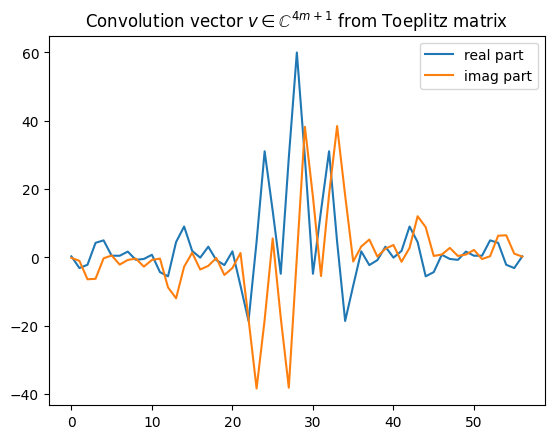

In [ ]:
plt.plot(v_from_toeplitz.real, label="real part")
plt.plot(v_from_toeplitz.imag, label="imag part")
plt.legend()
plt.title(r'Convolution vector $v \in \mathbb{C}^{4m+1}$ from Toeplitz matrix')
plt.show()

In [ ]:
random_vector = torch.randn(mtot, dtype=torch.complex128)

In [ ]:
toeplitz_times_random_vector = toeplitz_mat.to(dtype=torch.complex128) @ random_vector.to(dtype=torch.complex128)

In [ ]:
convolution_output = FFTConv1d(v_from_toeplitz.flip(0), random_vector)() # flip is needed also in the FFT. 

In [ ]:
# they should be the same
assert torch.allclose(toeplitz_times_random_vector, convolution_output, rtol=1e-5, atol=1e-8), "toeplitz_times_random_vector and convolution_output are not the same"


In [ ]:
v_manual = compute_convolution_vector_vectorized(m=m, x=x, h=h)
assert torch.allclose(v_from_toeplitz, v_manual[0], rtol=1e-5, atol=1e-4), "v_from_toeplitz and v_manual are not the same"


AssertionError: v_from_toeplitz and v_manual are not the same

In [ ]:
# toeplitz times random vector
toeplitz_product = toeplitz_mat.to(dtype=torch.complex128) @ random_vector.to(dtype=torch.complex128)



In [ ]:
# compute the v convolution vector
v, j_indices = compute_convolution_vector_vectorized(m=m, x=x, h=h)


In [ ]:
valid_conv_output = FFTConv1d(v, random_vector)()

In [ ]:
toeplitz_mat_from_

In [ ]:
# toeplitz multiplication
toeplitz_mat = F.conj().T @ F
toeplitz_product = toeplitz_mat.to(dtype=torch.complex128) @ random_vector.to(dtype=torch.complex128)
assert torch.allclose(valid_conv_output, toeplitz_product, rtol=1e-5, atol=1e-4), "valid_conv_output and toeplitz_product are not the same"


AssertionError: valid_conv_output and toeplitz_product are not the same

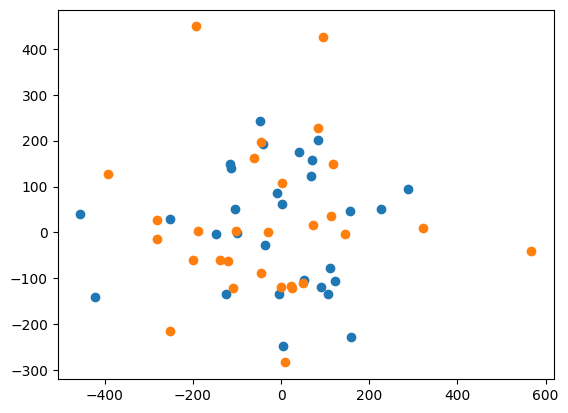

In [ ]:
plt.scatter(valid_conv_output.real, valid_conv_output.imag, label='valid_conv_output')
plt.scatter(toeplitz_product.real, toeplitz_product.imag, label='toeplitz_product')

In [ ]:
# Construct the right hand side D @ F^* @ y
F = F.to(dtype=torch.complex128)
D = torch.diag(ws).to(dtype=torch.complex128)
rhs = D @ torch.conj(F).T @ y.to(dtype=torch.complex128) # y to complex dtype temporarily




In [ ]:
assert rhs.shape[0] == mtot, "rhs should have length mtot"

In [ ]:
v, j_indices = compute_convolution_vector_vectorized(m=m, x=x, h=h)
assert v.shape[0] == 4*m + 1, "v should have length 4m + 1"

In [ ]:
random_vector = torch.randn(mtot, dtype=torch.complex128)
print("random_vector.shape: ", random_vector.shape)


random_vector.shape:  torch.Size([29])


In [ ]:
output_conv = compute_valid_convolution(v, random_vector)

In [ ]:
np_conv = np.convolve(v.numpy(), random_vector.numpy(), mode='valid')
assert torch.allclose(output_conv, torch.tensor(np_conv, dtype=torch.complex128), rtol=1e-5, atol=1e-4), "output_conv and np_conv are not the same"


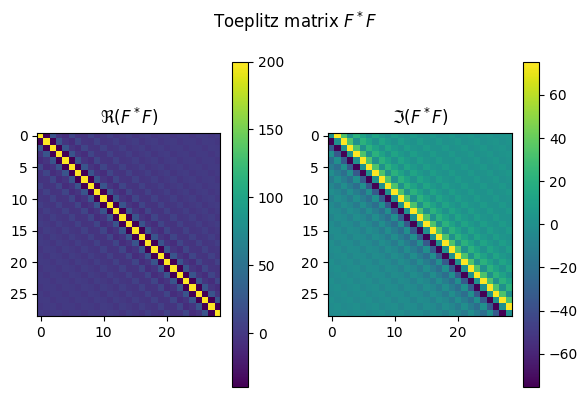

In [ ]:
toeplitz_mat = F.conj().T @ F
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 4))
im1 = ax1.imshow(toeplitz_mat.real)
plt.colorbar(im1, ax=ax1)
ax1.set_title(r'$\Re(F^*F)$')
im2 = ax2.imshow(toeplitz_mat.imag)
plt.colorbar(im2, ax=ax2)
ax2.set_title(r'$\Im(F^*F)$')
plt.suptitle(r'Toeplitz matrix $F^*F$')
plt.tight_layout()
plt.show()

In [ ]:
toeplitz_mat

tensor([[ 2.0000e+02+0.0000e+00j, -3.9661e+01+7.5494e+01j,
          2.2946e+01+3.3301e+01j, -2.8381e+00+3.4111e-01j,
         -7.9267e+00+2.0799e+01j,  1.0040e+01+1.1379e+01j,
         -2.7676e+00+6.7500e-01j, -3.1857e+00+1.2769e+01j,
          6.5576e+00+5.8476e+00j, -2.6519e+00+9.9465e-01j,
         -1.1774e+00+9.3781e+00j,  4.7857e+00+3.3350e+00j,
         -2.4940e+00+1.2935e+00j, -3.9101e-02+7.4004e+00j,
          3.6284e+00+1.9307e+00j, -2.2976e+00+1.5654e+00j,
          6.9288e-01+6.0338e+00j,  2.7683e+00+1.0718e+00j,
         -2.0676e+00+1.8049e+00j,  1.1885e+00+4.9874e+00j,
          2.0824e+00+5.3126e-01j, -1.8095e+00+2.0077e+00j,
          1.5253e+00+4.1329e+00j,  1.5149e+00+1.9834e-01j,
         -1.5295e+00+2.1702e+00j,  1.7442e+00+3.4069e+00j,
          1.0383e+00+1.0977e-02j, -1.2341e+00+2.2900e+00j,
          1.8700e+00+2.7763e+00j],
        [-3.9661e+01-7.5494e+01j,  2.0000e+02+0.0000e+00j,
         -3.9661e+01+7.5494e+01j,  2.2946e+01+3.3301e+01j,
         -2.8381e+00+

In [ ]:
def is_toeplitz(matrix, rtol=1e-5, atol=1e-4):
    """
    Check if a matrix is Toeplitz by verifying that all diagonals are constant.
    
    Args:
        matrix: torch.Tensor, the matrix to check
        rtol: float, relative tolerance for comparison
        atol: float, absolute tolerance for comparison
    
    Returns:
        bool: True if matrix is Toeplitz, False otherwise
    """
    n = matrix.shape[0]
    try:
        for k in range(n):
            # Get the k-th diagonal (above main diagonal)
            diag = torch.diagonal(matrix, offset=k)
            if not torch.allclose(diag, diag[0] * torch.ones_like(diag), rtol=rtol, atol=atol):
                return False
            
            if k > 0:
                # Get the k-th diagonal (below main diagonal)
                diag = torch.diagonal(matrix, offset=-k)
                if not torch.allclose(diag, diag[0] * torch.ones_like(diag), rtol=rtol, atol=atol):
                    return False
        return True
    except:
        return False

# Check if toeplitz_mat is indeed Toeplitz
assert is_toeplitz(toeplitz_mat), "Matrix is not Toeplitz"


In [ ]:
output_multiplication = toeplitz_mat.to(dtype=torch.complex128) @ random_vector.to(dtype=torch.complex128)

In [ ]:
output_conv.dtype

torch.complex128

In [ ]:
assert torch.allclose(output_conv, output_multiplication, rtol=1e-5, atol=1e-4), "output_conv and output_multiplication are not the same"

AssertionError: output_conv and output_multiplication are not the same

In [ ]:
output_conv.shape

torch.Size([29])

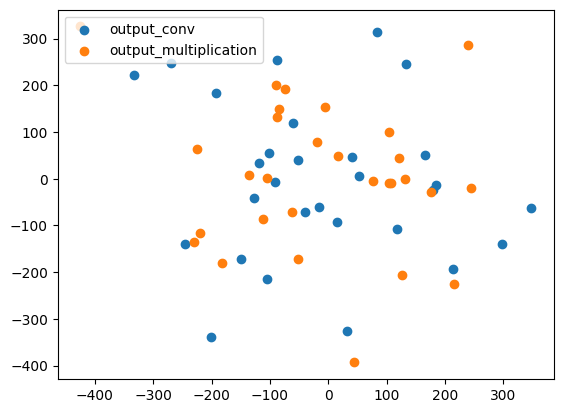

In [ ]:
plt.scatter(output_conv.real, output_conv.imag, label='output_conv')
plt.scatter(output_multiplication.real, output_multiplication.imag, label='output_multiplication')
plt.legend()
plt.show()


In [ ]:
import torch
import torch.nn.functional as F

# Define the input vector x and kernel k
N = 10  # Length of input vector
M = 3   # Length of kernel

# Random input vector and kernel
x = torch.randn(N)
k = torch.randn(M)

# Perform convolution using PyTorch's conv1d
# Reshape x and k to match conv1d input requirements
x_reshaped = x.view(1, 1, -1)  # Shape: (batch_size, channels, length)
k_reshaped = k.view(1, 1, -1)  # Shape: (out_channels, in_channels/groups, kernel_size)

# Perform convolution
y_conv = F.conv1d(x_reshaped, k_reshaped)
y_conv_flat = y_conv.view(-1)

# Construct the Toeplitz matrix T
L_out = N - M + 1  # Output length after convolution
T = torch.zeros(L_out, N)

# Fill the Toeplitz matrix
for i in range(L_out):
    T[i, i:i+M] = k

# Multiply the Toeplitz matrix by the input vector
y_toeplitz = T @ x

# Compare the results
print("Convolution result:")
print(y_conv_flat)
print("\nToeplitz multiplication result:")
print(y_toeplitz)
print("\nDifference between convolution and Toeplitz multiplication:")
print(torch.norm(y_conv_flat - y_toeplitz))


Convolution result:
tensor([ 1.2562,  0.6347, -0.2914, -1.1217, -0.8059,  0.6168,  0.5111, -1.0327])

Toeplitz multiplication result:
tensor([ 1.2562,  0.6347, -0.2914, -1.1217, -0.8059,  0.6168,  0.5111, -1.0327])

Difference between convolution and Toeplitz multiplication:
tensor(1.4901e-07)


In [ ]:
import torch
import numpy as np

# Set a fixed integer m
m = 14

def compute_valid_convolution(v: torch.Tensor, b: torch.Tensor) -> torch.Tensor:
    # Extract m from input sizes
    size_v = v.shape[0]
    size_b = b.shape[0]
    
    # size_v should be 4m+1 for some integer m
    # size_b should be 2m+1 for the same m
    assert (size_v - 1) % 4 == 0, "v must have size 4m+1 for some integer m"
    m = (size_v - 1) // 4
    assert size_b == 2*m + 1, "b must have size 2m+1 where m is derived from v's size"

    # Pad the vector b to resize to size_v
    b_padded = torch.zeros(size_v)
    b_padded[:size_b] = b  # Pad with zeros at the end

    # Compute the convolution via FFTs
    # The length of the convolution output is L = N + M - 1
    L = size_v + size_b - 1

    # Pad both v and b_padded to length L
    v_padded = torch.zeros(L)
    v_padded[:size_v] = v

    b_padded_L = torch.zeros(L)
    b_padded_L[:size_b] = b

    # Compute FFTs of the padded vectors
    V_fft = torch.fft.fft(v_padded)
    B_fft = torch.fft.fft(b_padded_L)

    # Perform element-wise multiplication in the frequency domain
    Y_fft = V_fft * B_fft

    # Compute the inverse FFT to get the convolution result
    y_conv = torch.fft.ifft(Y_fft).real

    # Extract the valid elements (2m+1 elements) from the convolution result
    # The valid convolution output corresponds to indices from size_b - 1 to size_v
    y_valid = y_conv[size_b - 1:size_v]
    
    return y_valid

v = torch.randn(4*m + 1)
b = torch.randn(2*m + 1)

y_valid = compute_valid_convolution(v, b)
# For comparison, compute the valid convolution using NumPy's convolve function
y_direct = np.convolve(v.numpy(), b.numpy(), mode='valid')

# Compare the outputs
diff = np.linalg.norm(y_valid.numpy() - y_direct)
print(f'Difference between FFT-based convolution and direct convolution (valid outputs): {diff}')

Difference between FFT-based convolution and direct convolution (valid outputs): 2.929113634309033e-06
